In [2]:
import argparse
import pandas as pd
import numpy as np
from numpy import savez_compressed, load
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from functools import reduce
en_stopwords = set(stopwords.words('english')) 
import itertools
import re
import time
import os
import pickle

import datasets
from datasets import load_dataset, load_metric, Dataset, concatenate_datasets,DatasetDict
from datasets import load_from_disk
from tqdm import tqdm
tqdm.pandas(position=0,leave=True)


import textwrap

import transformers

from transformers import (
    AdamW,
    AutoConfig,
    AutoModelWithLMHead,
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    get_linear_schedule_with_warmup,
)
print("Transformers version is {}".format(transformers.__version__))

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from IPython.display import display, HTML

from collections import Counter
from wordcloud import WordCloud

sns.set(style="whitegrid",palette='muted',font_scale=1.2)
rcParams['figure.figsize']=16,10

%config InlineBackend.figure_format="retina"
%matplotlib inline

pd.set_option('display.max_columns', None,'display.max_rows',None)

Transformers version is 4.20.1


In [3]:
email_all=load_from_disk(os.path.join(os.getcwd(),"dataset","email_all"))
email_all

DatasetDict({
    train: Dataset({
        features: ['Full_TextBody', 'Client_TextBody', 'Latest_TextBody', 'year', 'churn'],
        num_rows: 156414
    })
    test: Dataset({
        features: ['Full_TextBody', 'Client_TextBody', 'Latest_TextBody', 'year', 'churn'],
        num_rows: 27497
    })
})

In [4]:
train_data=email_all['train']
test_data=email_all['test']
train_data.set_format(type="pandas")
df_train=train_data[:]
test_data.set_format(type="pandas")
df_test=test_data[:]

In [5]:
tempt1=pd.DataFrame(df_train["churn"].value_counts(dropna=False)).reset_index().rename(columns={'index':'churn','churn':'count'})
tempt2=pd.DataFrame(df_train["churn"].value_counts(dropna=False,normalize=True)).reset_index().rename(columns={'index':'churn','churn':'percentage'})
tempt1.merge(tempt2, on="churn", how="inner").style.format({'count':'{:,}','percentage':'{:.2%}'}).set_caption("Training set churn dist")\
.set_table_styles([{'selector': 'caption','props': [('color', 'red'),('font-size', '15px')]}])

,churn,count,percentage
0,0,"133,904",85.61%
1,1,"22,510",14.39%


In [6]:
tempt1=pd.DataFrame(df_test["churn"].value_counts(dropna=False)).reset_index().rename(columns={'index':'churn','churn':'count'})
tempt2=pd.DataFrame(df_test["churn"].value_counts(dropna=False,normalize=True)).reset_index().rename(columns={'index':'churn','churn':'percentage'})
tempt1.merge(tempt2, on="churn", how="inner").style.format({'count':'{:,}','percentage':'{:.2%}'}).set_caption("Test set churn dist")\
.set_table_styles([{'selector': 'caption','props': [('color', 'red'),('font-size', '15px')]}])

,churn,count,percentage
0,0,"23,786",86.50%
1,1,"3,711",13.50%


In [7]:
df_train.head()

,Full_TextBody,Client_TextBody,Latest_TextBody,year,churn
0,the pa called to advise this employee went to ...,this is becoming a trend. the ml screen needs ...,thank you for your call. as we discussed i hav...,2020,0
1,i am wondering if there were any changes made ...,i am wondering if there were any changes made ...,please find attached the requested invoice for...,2020,0
2,could you please terminate kerry lynn ellis xx...,could you please terminate kerry lynn ellis xx...,i have confirmed the termination for kerry lyn...,2020,0
3,please provide any conversion paperwork the be...,please provide any conversion paperwork the be...,thank you for your email. i have attached the ...,2019,0
4,comment one of my employees is a member of the...,comment one of my employees is a member of the...,there is no account team information in cme fo...,2019,0


In [8]:
from datasets import Dataset
model_checkpoint="allenai/longformer-base-4096"
tokenizer=AutoTokenizer.from_pretrained(model_checkpoint)

In [9]:
train_df1=Dataset.from_pandas(df_train)
train_df1=train_df1.map(lambda x: tokenizer(x["Full_TextBody"]),batched=True)

test_df1=Dataset.from_pandas(df_test)
test_df1=test_df1.map(lambda x: tokenizer(x["Full_TextBody"]),batched=True)

def compute_lenth(example):
    return {"text_length":len(example["input_ids"])}
train_df1=train_df1.map(compute_lenth)
test_df1=test_df1.map(compute_lenth)

  0%|          | 0/157 [00:00<?, ?ba/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (4720 > 4096). Running this sequence through the model will result in indexing errors


  0%|          | 0/28 [00:00<?, ?ba/s]

  0%|          | 0/156414 [00:00<?, ?ex/s]

  0%|          | 0/27497 [00:00<?, ?ex/s]

In [10]:
train_df2=Dataset.from_pandas(df_train)
train_df2=train_df2.filter(lambda x: x["Client_TextBody"]!=None)
train_df2=train_df2.map(lambda x: tokenizer(x["Client_TextBody"]),batched=True)

test_df2=Dataset.from_pandas(df_test)
test_df2=test_df2.filter(lambda x: x["Client_TextBody"]!=None)
test_df2=test_df2.map(lambda x: tokenizer(x["Client_TextBody"]),batched=True)

def compute_lenth(example):
    return {"text_length":len(example["input_ids"])}
train_df2=train_df2.map(compute_lenth)
test_df2=test_df2.map(compute_lenth)

  0%|          | 0/157 [00:00<?, ?ba/s]

  0%|          | 0/141 [00:00<?, ?ba/s]

  0%|          | 0/28 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/140903 [00:00<?, ?ex/s]

  0%|          | 0/24863 [00:00<?, ?ex/s]

In [11]:
train_df3=Dataset.from_pandas(df_train)
train_df3=train_df3.map(lambda x: tokenizer(x["Latest_TextBody"]),batched=True)

test_df3=Dataset.from_pandas(df_test)
test_df3=test_df3.map(lambda x: tokenizer(x["Latest_TextBody"]),batched=True)

def compute_lenth(example):
    return {"text_length":len(example["input_ids"])}
train_df3=train_df3.map(compute_lenth)
test_df3=test_df3.map(compute_lenth)

  0%|          | 0/157 [00:00<?, ?ba/s]

  0%|          | 0/28 [00:00<?, ?ba/s]

  0%|          | 0/156414 [00:00<?, ?ex/s]

  0%|          | 0/27497 [00:00<?, ?ex/s]

In [12]:
def statistics_compute(hf_df1,hf_df2,p=1):

    X=[]
    X.append(np.percentile(hf_df1['text_length'],p))
    X.append(np.percentile(hf_df2['text_length'],p))
    
    result={}
    result['percentile']=X
    result["min"]=[np.min(hf_df1['text_length']),np.min(hf_df2['text_length'])]
    result["max"]=[np.max(hf_df1['text_length']),np.max(hf_df2['text_length'])]
    result["mean"]=[np.mean(hf_df1['text_length']),np.mean(hf_df2['text_length'])]
    return result

def statistics_table(hf_df1,hf_df2):
    dict_data={}
    dict_data["data_type"]=["training", "test"]
    dict_data["# of obs"]=[len(hf_df1['text_length']),len(hf_df2['text_length'])]
    dict_data["Min of tokens"]=statistics_compute(hf_df1, hf_df2)["min"]
    dict_data["1% of tokens"]=statistics_compute(hf_df1, hf_df2, p=1)['percentile']
    dict_data["5% of tokens"]=statistics_compute(hf_df1, hf_df2, p=5)['percentile']
    dict_data["10% of tokens"]=statistics_compute(hf_df1, hf_df2, p=10)['percentile']
    dict_data["25% of tokens"]=statistics_compute(hf_df1, hf_df2, p=25)['percentile']
    dict_data["Median of tokens"]=statistics_compute(hf_df1, hf_df2, p=50)['percentile']
    dict_data["Average tokens"]=statistics_compute(hf_df1, hf_df2)["mean"]
    dict_data["75% of tokens"]=statistics_compute(hf_df1, hf_df2, p=75)['percentile']
    dict_data["90% of tokens"]=statistics_compute(hf_df1, hf_df2, p=90)['percentile']
    dict_data["95% of tokens"]=statistics_compute(hf_df1, hf_df2, p=95)['percentile']
    dict_data["99% of tokens"]=statistics_compute(hf_df1, hf_df2, p=99)['percentile']
    dict_data["Max of tokens"]=statistics_compute(hf_df1, hf_df2)["max"]
    token_count_df=pd.DataFrame(dict_data)
    return token_count_df

def style_format(token_count_df,  textbody="Full_TextBody"):
    token_count_df=token_count_df.set_index("data_type")
    token_count_df[list(token_count_df.columns)] = token_count_df[list(token_count_df.columns)].astype(int)
    return token_count_df.style.format("{:,}").set_caption(f"Summary Statistics of token lengths for {textbody} ").set_table_styles([{
        'selector': 'caption',
        'props': [
            ('color', 'red'),
            ('font-size', '20px')
        ]
    }])

In [13]:
token_count_df=statistics_table(train_df1,test_df1)
style_format(token_count_df,  textbody="Full_TextBody")

,# of obs,Min of tokens,1% of tokens,5% of tokens,10% of tokens,25% of tokens,Median of tokens,Average tokens,75% of tokens,90% of tokens,95% of tokens,99% of tokens,Max of tokens
data_type,,,,,,,,,,,,,
training,"156,414",11,54,86,132,286,731,"1,501","1,785","3,674","5,338","10,572","104,305"
test,"27,497",12,63,101,153,337,869,"1,723","2,090","4,093","6,018","12,725","61,064"


In [14]:
token_count_df=statistics_table(train_df2,test_df2)
style_format(token_count_df,  textbody="Client_TextBody")

,# of obs,Min of tokens,1% of tokens,5% of tokens,10% of tokens,25% of tokens,Median of tokens,Average tokens,75% of tokens,90% of tokens,95% of tokens,99% of tokens,Max of tokens
data_type,,,,,,,,,,,,,
training,"140,903",7,17,33,56,142,366,784,917,"1,908","2,834","5,692","94,220"
test,"24,863",12,17,38,66,159,421,890,"1,045","2,146","3,152","6,749","31,379"


In [15]:
token_count_df=statistics_table(train_df3,test_df3)
style_format(token_count_df,  textbody="Latest_TextBody")

,# of obs,Min of tokens,1% of tokens,5% of tokens,10% of tokens,25% of tokens,Median of tokens,Average tokens,75% of tokens,90% of tokens,95% of tokens,99% of tokens,Max of tokens
data_type,,,,,,,,,,,,,
training,"156,414",7,27,57,72,137,324,616,744,"1,463","2,100","4,079","66,315"
test,"27,497",12,29,69,88,169,401,742,903,"1,704","2,430","5,248","30,466"


In [16]:
train_df1.set_format("pandas")
df1_train=train_df1[:]
train_df2.set_format("pandas")
df2_train=train_df2[:]
train_df3.set_format("pandas")
df3_train=train_df3[:]

test_df1.set_format("pandas")
df1_test=train_df1[:]
test_df2.set_format("pandas")
df2_test=test_df2[:]
test_df3.set_format("pandas")
df3_test=test_df3[:]

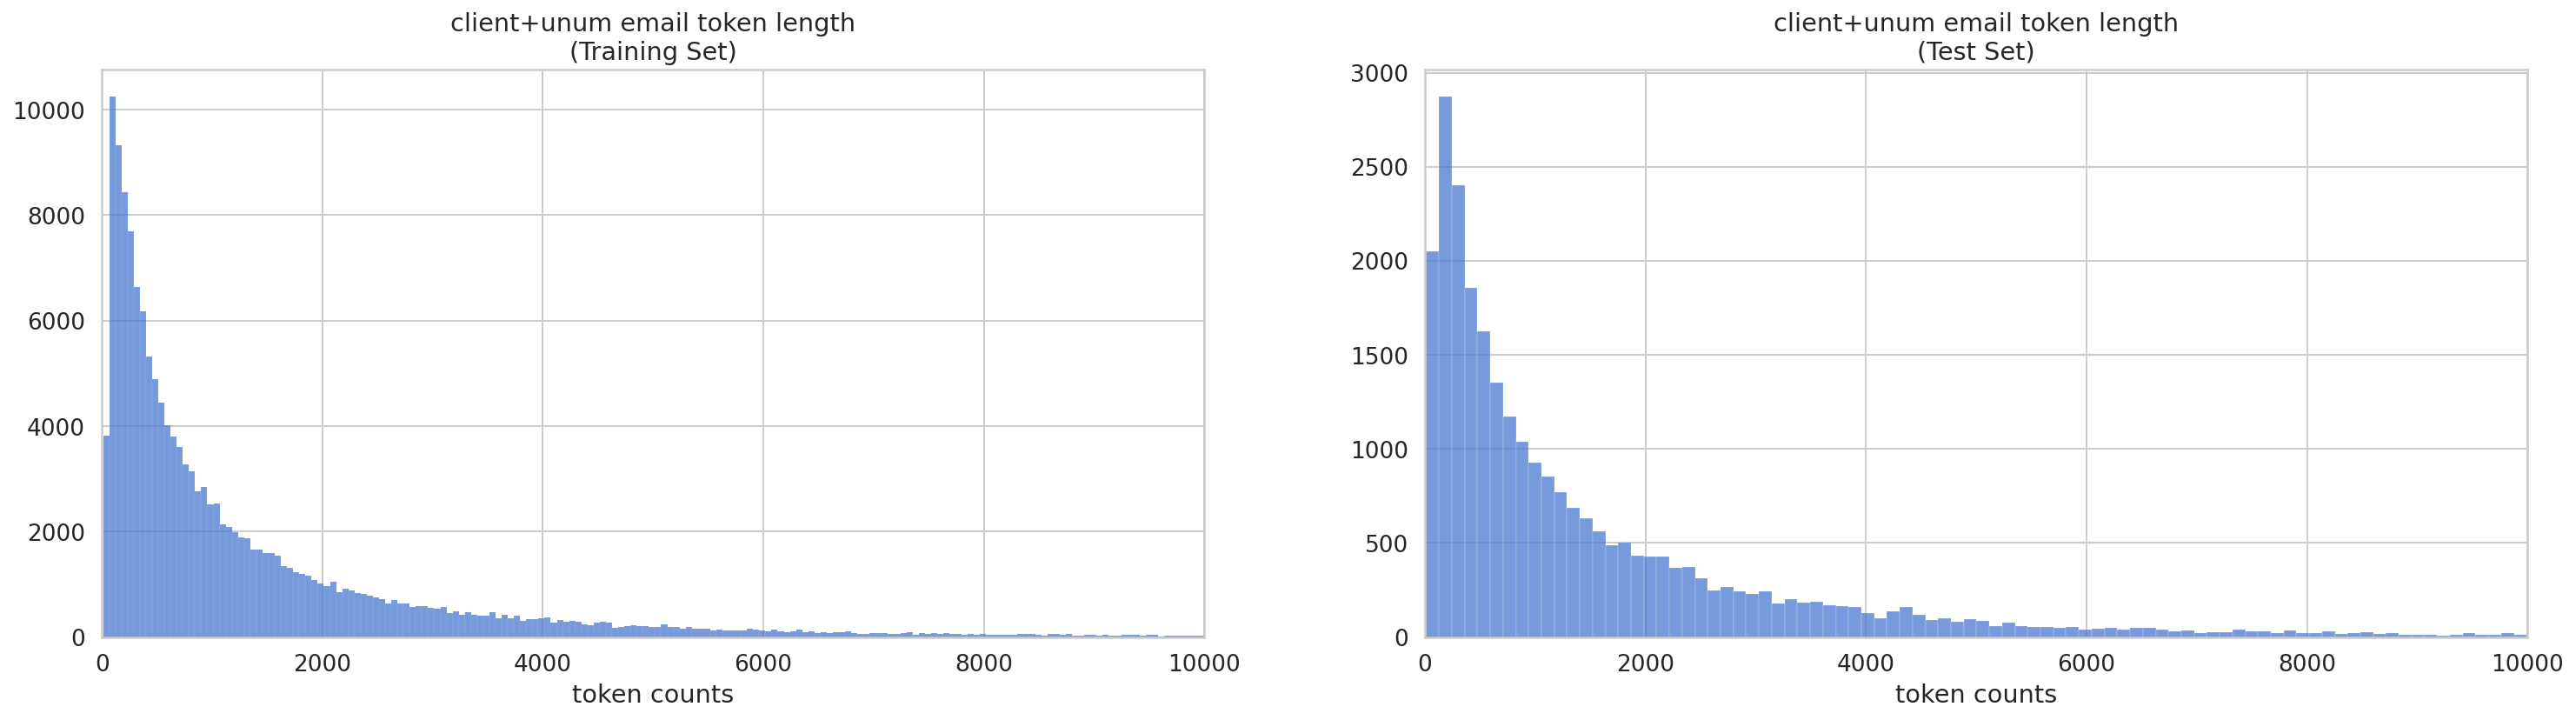

In [17]:
fig,(ax1,ax2)=plt.subplots(1,2, figsize=(25,6))
sns.histplot(train_df1['text_length'],ax=ax1)
ax1.set_title("client+unum email token length\n(Training Set)")
ax1.set_xlabel("token counts")
ax1.set_ylabel("")
ax1.set(xlim=(0, 10000))

sns.histplot(test_df1['text_length'],ax=ax2)
ax2.set_title("client+unum email token length\n(Test Set)")
ax2.set_xlabel("token counts")
ax2.set_ylabel("")
ax2.set(xlim=(0, 10000))
plt.show()

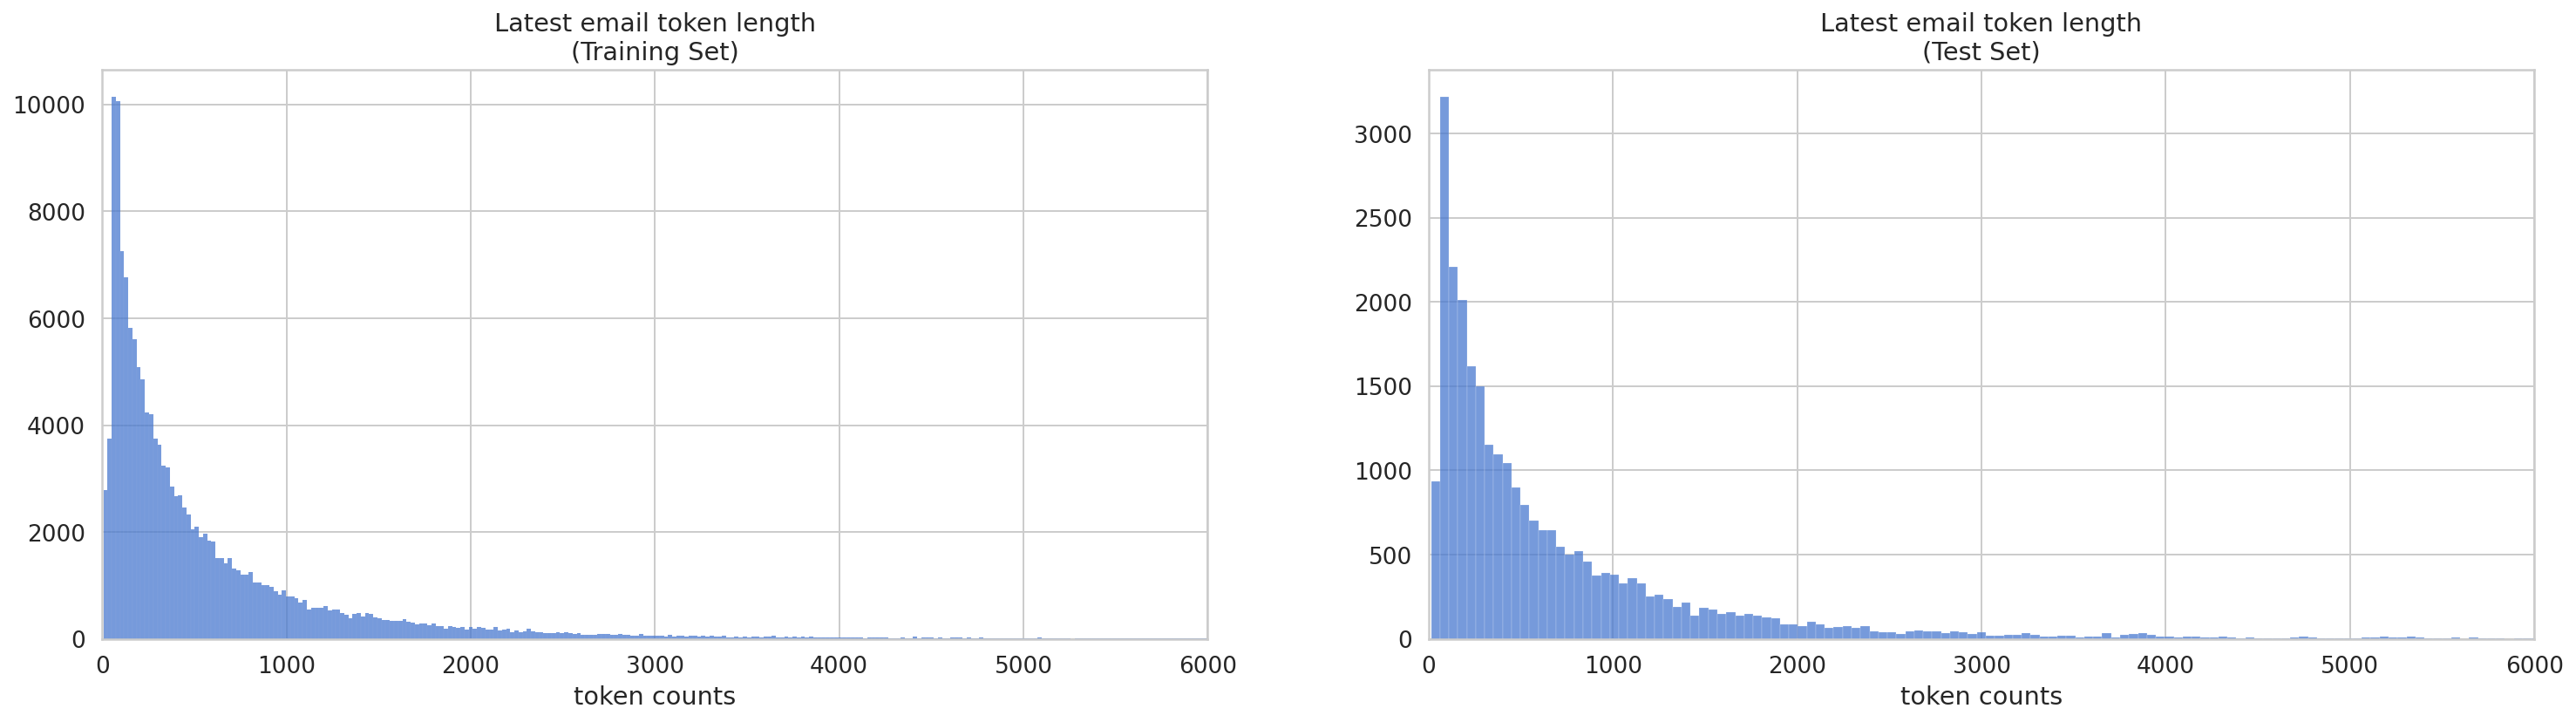

In [18]:
fig,(ax1,ax2)=plt.subplots(1,2, figsize=(25,6))
sns.histplot(train_df3['text_length'],ax=ax1)
ax1.set_title("Latest email token length\n(Training Set)")
ax1.set_xlabel("token counts")
ax1.set_ylabel("")
ax1.set(xlim=(0, 6000))

sns.histplot(test_df3['text_length'],ax=ax2)
ax2.set_title("Latest email token length\n(Test Set)")
ax2.set_xlabel("token counts")
ax2.set_ylabel("")
ax2.set(xlim=(0, 6000))
plt.show()

In [19]:
from datasets import Dataset
hf_train=Dataset.from_pandas(df_train)
hf_test=Dataset.from_pandas(df_test)
model_checkpoint="allenai/longformer-base-4096"
tokenizer=AutoTokenizer.from_pretrained(model_checkpoint)
        
for text in ["Full_TextBody", "Latest_TextBody"]:
    hf_train=hf_train.map(lambda x : tokenizer(x[text]),batched=True)
    hf_train=hf_train.remove_columns("attention_mask")
    hf_train=hf_train.rename_column(original_column_name="input_ids", new_column_name=text+"_input_ids")
    # hf_dataset = hf_dataset.filter(lambda x: len(x[text+"_input_ids"]) > self.min_tokens)
    
    hf_test=hf_test.map(lambda x : tokenizer(x[text]),batched=True)
    hf_test=hf_test.remove_columns("attention_mask")
    hf_test=hf_test.rename_column(original_column_name="input_ids", new_column_name=text+"_input_ids")
    
hf_train.set_format(type="pandas")
df_train=hf_train[:]

hf_test.set_format(type="pandas")
df_test=hf_test[:]

  0%|          | 0/157 [00:00<?, ?ba/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (4720 > 4096). Running this sequence through the model will result in indexing errors


  0%|          | 0/28 [00:00<?, ?ba/s]

  0%|          | 0/157 [00:00<?, ?ba/s]

  0%|          | 0/28 [00:00<?, ?ba/s]

In [20]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')
from nltk.tokenize import word_tokenize
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.preprocessing import STOPWORDS
all_stopwords_gensim = STOPWORDS.union(set(['thank','thanks', 'you', 'help','questions','a.m.','p.m.','friday','thursday','wednesday','tuesday','monday',\
                                            'askunum','email','askunum.com','unum','askunumunum.com','day','use', 'appreciate','available','mailtoaskunumunum.com',\
                                            'hello','hi','online','?','.','. .','phone','needs','need','let','know','service','information','time','meet','client',\
                                           'team','ask','file','date','opportunity','original','benefit','eastern','specialists','specialist','attached','experienced',\
                                            'benefits insurance','employee','click','organization','httpsbit.lycjrbm',  'received', 'billing', 'manager', 'assist', \
                                            'additional', 'response']))


## remove stop word
df_train["Full_TextBody"] = df_train["Full_TextBody"].apply(lambda x: ' '.join([word for word in x.split() if word not in (all_stopwords_gensim)]))
df_test["Full_TextBody"] = df_test["Full_TextBody"].apply(lambda x: ' '.join([word for word in x.split() if word not in (all_stopwords_gensim)]))

df_train["Latest_TextBody"] = df_train["Latest_TextBody"].apply(lambda x: ' '.join([word for word in x.split() if word not in (all_stopwords_gensim)]))
df_test["Latest_TextBody"] = df_test["Latest_TextBody"].apply(lambda x: ' '.join([word for word in x.split() if word not in (all_stopwords_gensim)]))

## removing non-english words from text
words = set(nltk.corpus.words.words())
df_train["Full_TextBody"] = df_train["Full_TextBody"].apply(lambda x: " ".join(w for w in nltk.wordpunct_tokenize(x) if w.lower() in words or not w.isalpha()))
df_test["Full_TextBody"] = df_test["Full_TextBody"].apply(lambda x: " ".join(w for w in nltk.wordpunct_tokenize(x) if w.lower() in words or not w.isalpha()))

df_train["Latest_TextBody"] = df_train["Latest_TextBody"].apply(lambda x: " ".join(w for w in nltk.wordpunct_tokenize(x) if w.lower() in words or not w.isalpha()))
df_test["Latest_TextBody"] = df_test["Latest_TextBody"].apply(lambda x: " ".join(w for w in nltk.wordpunct_tokenize(x) if w.lower() in words or not w.isalpha()))

## removing punctuation
df_train["Full_TextBody"]=df_train["Full_TextBody"].str.replace(r'[^\w\s]+', '')
df_test["Full_TextBody"]=df_test["Full_TextBody"].str.replace(r'[^\w\s]+', '')

df_train["Latest_TextBody"]=df_train["Full_TextBody"].str.replace(r'[^\w\s]+', '')
df_test["Latest_TextBody"]=df_test["Full_TextBody"].str.replace(r'[^\w\s]+', '')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: The default value of regex will change from True to False in a future version.
/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: The default value of regex will change from True to False in a future version.
/home/

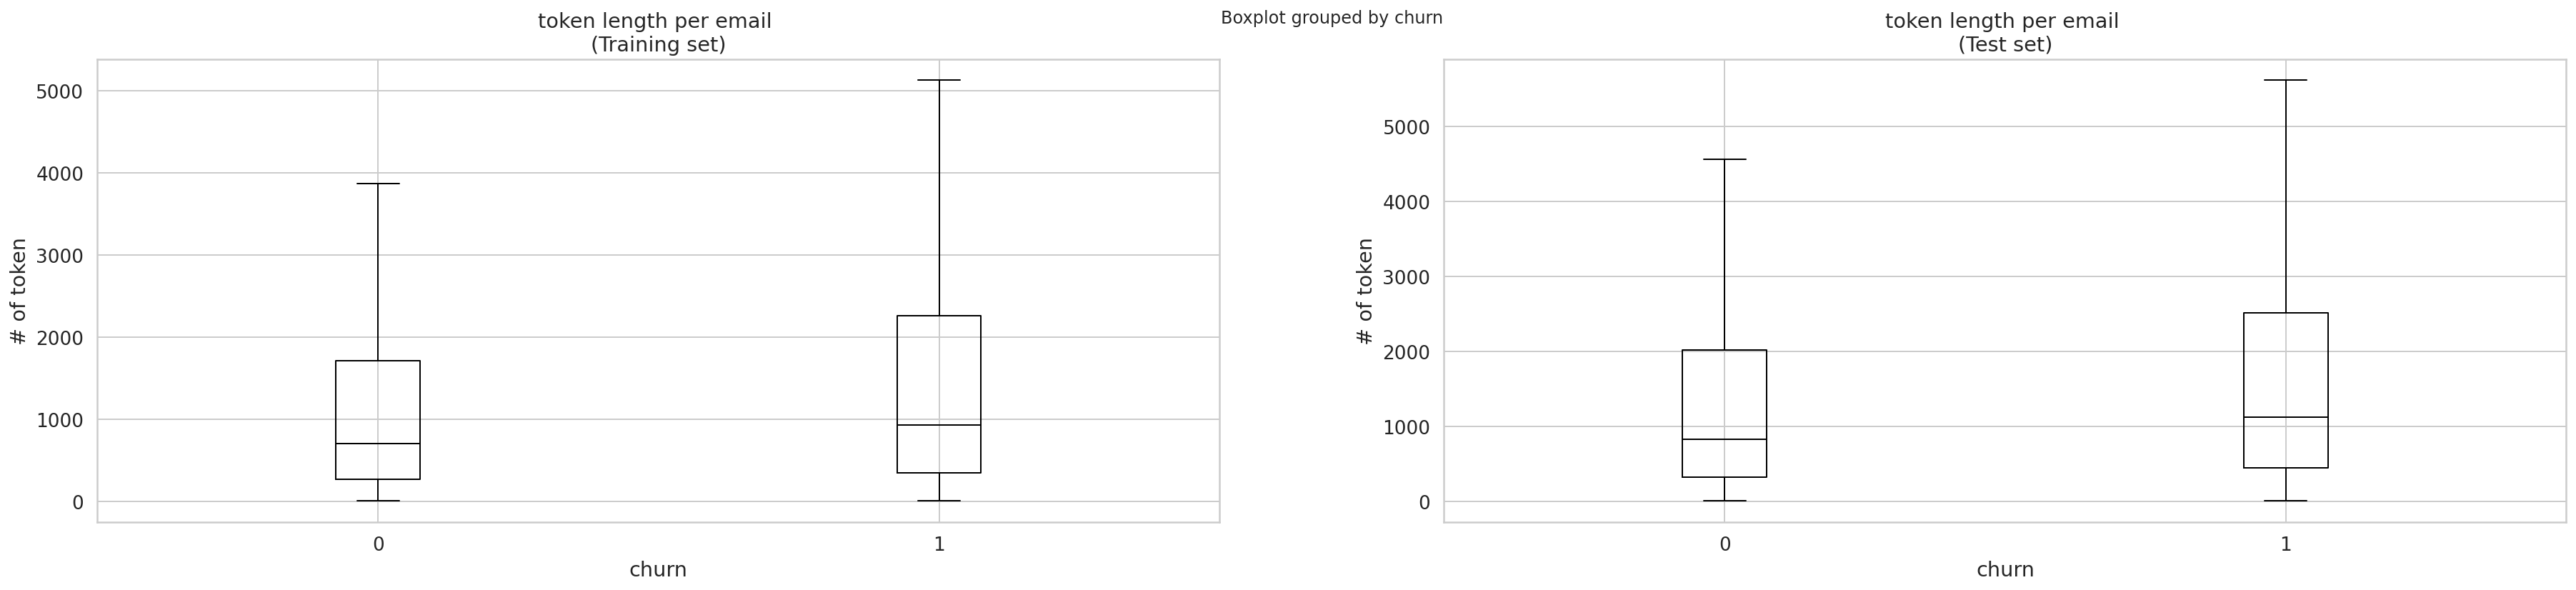

In [21]:
fig,(ax1,ax2)=plt.subplots(1,2, figsize=(30,6))
df_train["Full_Words_length"] = df_train["Full_TextBody_input_ids"].apply(len)
df_train.boxplot("Full_Words_length", by="churn", grid=True, showfliers=False,color="black",ax=ax1)
ax1.set_title("token length per email \n(Training set)")
ax1.set_ylabel("# of token")
df_test["Full_Words_length"] = df_test["Full_TextBody_input_ids"].apply(len)
df_test.boxplot("Full_Words_length", by="churn", grid=True, showfliers=False,color="black",ax=ax2)
ax2.set_title("token length per email \n(Test set)")
ax2.set_ylabel("# of token")
plt.show()

In [ ]:
train_word=[]
for index, row in tqdm(df_train.iterrows(), total=df_train.shape[0]):
    text_tokens = word_tokenize(row["Full_TextBody"])
    filter_text = [word for word in text_tokens if not word in all_stopwords_gensim]
    # train_word.extend(filter_text.lower().split())
    train_word.extend(filter_text)
    
train_dict=Counter(train_word)
cloud = WordCloud(max_font_size=80,colormap="hsv").generate_from_frequencies(train_dict)
plt.figure(figsize=(20,15))
plt.title("word frequency in Training set", fontsize=25,color="red")
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

 80%|███████▉  | 125108/156414 [02:48<00:41, 754.81it/s]

In [ ]:
test_word=[]
for index, row in tqdm(df_test.iterrows(), total=df_test.shape[0]):
    text_tokens = word_tokenize(row["Full_TextBody"])
    filter_text = [word for word in text_tokens if not word in all_stopwords_gensim]
    # test_word.extend(filter_text.lower().split())
    test_word.extend(filter_text)
    
test_dict=Counter(test_word)
cloud = WordCloud(max_font_size=80,colormap="hsv").generate_from_frequencies(test_dict)
plt.figure(figsize=(20,15))
plt.title("word frequency in Test set", fontsize=25,color="red")
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
train_word_positive=[]
df_train_positive=df_train[df_train["churn"]==1]
for index, row in tqdm(df_train_positive.iterrows(), total=df_train_positive.shape[0]):
    text_tokens = word_tokenize(row["Full_TextBody"])
    filter_text = [word for word in text_tokens if not word in all_stopwords_gensim]
    train_word_positive.extend(filter_text)
    
train_dict=Counter(train_word_positive)
cloud = WordCloud(max_font_size=80,colormap="hsv").generate_from_frequencies(train_dict)
plt.figure(figsize=(20,15))
plt.title("word frequency in Training set (churn=1)", fontsize=25,color="red")
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
test_word_positive=[]
df_test_positive=df_test[df_test["churn"]==1]
for index, row in tqdm(df_test_positive.iterrows(), total=df_test_positive.shape[0]):
    text_tokens = word_tokenize(row["Full_TextBody"])
    filter_text = [word for word in text_tokens if not word in all_stopwords_gensim]
    test_word_positive.extend(filter_text)
    
test_dict=Counter(test_word_positive)
cloud = WordCloud(max_font_size=80,colormap="hsv").generate_from_frequencies(test_dict)
plt.figure(figsize=(20,15))
plt.title("word frequency in Test set (churn=1)", fontsize=25,color="red")
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
def dummy_fun(doc):
    return doc.split()

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(input="content",analyzer='word',tokenizer=dummy_fun,max_features=1000)

In [ ]:
n=50
vectorizer.fit(df_train["Full_TextBody"])
df_tfidf = vectorizer.transform(df_train["Full_TextBody"])
vocab = np.array(vectorizer.get_feature_names())
tfidf_train = np.argsort(df_tfidf.toarray()).flatten()[::-1]
train_tfidf=pd.DataFrame({"rank":np.arange(n),"tfidf_train":vocab[tfidf_train][:n]})

vectorizer.fit(df_test["Full_TextBody"])
df_tfidf = vectorizer.transform(df_test["Full_TextBody"])
vocab = np.array(vectorizer.get_feature_names())
tfidf_test = np.argsort(df_tfidf.toarray()).flatten()[::-1]
test_tfidf=pd.DataFrame({"rank":np.arange(n),"tfidf_test":vocab[tfidf_test][:n]})

pd.merge(left=train_tfidf,right=test_tfidf, on="rank", how="inner")

In [ ]:
n=50

df_train_churn=df_train[df_train["churn"]==1]
vectorizer.fit(df_train_churn["Full_TextBody"])
df_tfidf = vectorizer.transform(df_train_churn["Full_TextBody"])
vocab = np.array(vectorizer.get_feature_names())
tfidf_train = np.argsort(df_tfidf.toarray()).flatten()[::-1]
train_tfidf=pd.DataFrame({"rank":np.arange(n),"tfidf_train":vocab[tfidf_train][:n]})

df_test_churn=df_test[df_test["churn"]==1]
vectorizer.fit(df_test_churn["Full_TextBody"])
df_tfidf = vectorizer.transform(df_test_churn["Full_TextBody"])
vocab = np.array(vectorizer.get_feature_names())
tfidf_test = np.argsort(df_tfidf.toarray()).flatten()[::-1]
test_tfidf=pd.DataFrame({"rank":np.arange(n),"tfidf_test":vocab[tfidf_test][:n]})

pd.merge(left=train_tfidf,right=test_tfidf, on="rank", how="inner")

In [132]:
pd.merge(left=train_tfidf,right=test_tfidf, on="rank", how="inner").shape

(50, 3)

In [133]:
pd.merge(left=train_tfidf,right=test_tfidf, on="rank", how="inner").drop_duplicates().shape

(50, 3)

In [126]:
train_data=email_all['train']
test_data=email_all['test']
train_data.set_format(type="pandas")
df_train=train_data[:]
test_data.set_format(type="pandas")
df_test=test_data[:]
from datasets import Dataset
hf_train=Dataset.from_pandas(df_train)
hf_test=Dataset.from_pandas(df_test)
model_checkpoint="allenai/longformer-base-4096"
tokenizer=AutoTokenizer.from_pretrained(model_checkpoint)
        
for text in ["Full_TextBody", "Latest_TextBody"]:
    hf_train=hf_train.map(lambda x : tokenizer(x[text]),batched=True)
    hf_train=hf_train.remove_columns("attention_mask")
    hf_train=hf_train.rename_column(original_column_name="input_ids", new_column_name=text+"_input_ids")
    # hf_dataset = hf_dataset.filter(lambda x: len(x[text+"_input_ids"]) > self.min_tokens)
    
    hf_test=hf_test.map(lambda x : tokenizer(x[text]),batched=True)
    hf_test=hf_test.remove_columns("attention_mask")
    hf_test=hf_test.rename_column(original_column_name="input_ids", new_column_name=text+"_input_ids")
    
hf_train.set_format(type="pandas")
df_train=hf_train[:]
hf_test.set_format(type="pandas")
df_test=hf_test[:]

df_train["Full_Words_length"] = df_train["Full_TextBody_input_ids"].apply(len)
df_test["Full_Words_length"] = df_test["Full_TextBody_input_ids"].apply(len)

import textwrap
import random

df_test_v1=df_test[(df_test.churn==1) & (df_test.Full_Words_length<=512)]
df_test_v1=df_test_v1.dropna(subset=["Client_TextBody"])
# Wrap text to 80 characters.
wrapper = textwrap.TextWrapper(width=150) 

exam_1 = df_test_v1["Full_TextBody"]
exam_2 = df_test_v1["Client_TextBody"]
exam_3 = df_test_v1["Latest_TextBody"]

# Randomly choose some examples.
for i in range(10):
    random.seed(101+i)
    j = random.choice(exam_1.index)
    
    print('')
    print("*"*50)
    print('*********  Full TextBody ********')
    print("*"*50)
    print('')
    print(wrapper.fill(exam_1[j]))
    print('')
    print("*"*50)
    print('*********  Client TextBody ********')
    print("*"*50)
    print('')
    print(wrapper.fill(exam_2[j]))
    print('')
    print("*"*50)
    print('*********  Latest Parent_ID TextBody ********')
    print("*"*50)
    print('')
    print(wrapper.fill(exam_3[j]))
    print('')
    print("*"*200)


**************************************************
*********  Full TextBody ********
**************************************************

please see the attached screenshot for turf tenders.nothing on left side trying to term employee. please advise how to fix this cidimage.pngda.fe

**************************************************
*********  Client TextBody ********
**************************************************

please see the attached screenshot for turf tenders.nothing on left side trying to term employee. please advise how to fix this cidimage.pngda.fe

**************************************************
*********  Latest Parent_ID TextBody ********
**************************************************

please see the attached screenshot for turf tenders.nothing on left side trying to term employee. please advise how to fix this cidimage.pngda.fe

*************************************************************************************************************************************